<a href="https://colab.research.google.com/github/LiuYuWei/ai-twinkle-llm-lab-llm-dialogue-dataset/blob/main/Simon_generate_dialogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 - 對話資料生成 & 對話集格式介紹

在這個 Lab，我們的目標是建立一份「可持續擴充」的對話資料集。主要的步驟如下：
1. 使用 OpenAI SDK 連 `Gemma-3-12B-it` API
2. 介紹對話資料的常見格式：**Alpaca**, **ShareGPT**，以及 **OpenAI** 格式（我們採用後者）
3. 探討 `.jsonl` 格式與 `.parquet` 格式的優缺點，並說明 HF Hub 對 parquet 的轉換支援
   (上傳 parquet 時 HF 會自動生成 `.parquet` 分支與 viewer)

## I. 初始化參數

In [1]:
from google.colab import userdata


請去申請 Google API Key 和 Huggingface API Key 然後放到 Colab 左邊有個鑰匙的地方，保護你的 Key

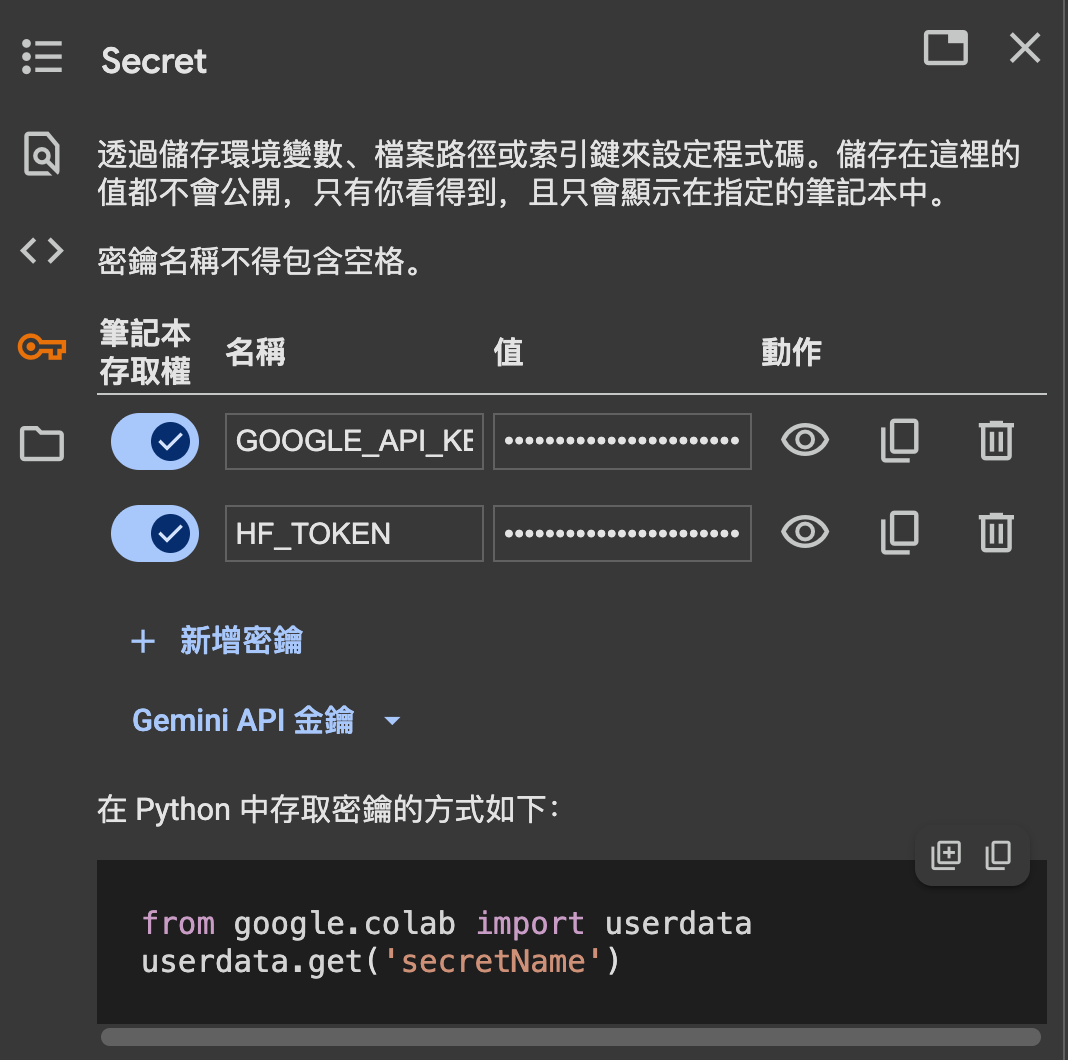

In [2]:
from openai import OpenAI

# 重新初始化 API client
API_KEY = userdata.get('GOOGLE_API_KEY')
BASE_URL = "https://generativelanguage.googleapis.com/v1beta/openai/"
MODEL = "gemma-3-27b-it"

client = OpenAI(
    api_key=API_KEY,
    base_url=BASE_URL
)

print("API client 已初始化")

API client 已初始化


## II. 常見對話資料集格式比較



<p align="center">
  <img src="https://github.com/ai-twinkle/llm-lab/blob/main/courses/2025-08-llm-dialogue-dataset/assets/01_wiki_data_format.png?raw=1" width="100%"/><br/>
  <em align="center">圖 1：Wiki 對話格式示意圖</em>
</p>

## JSONL vs Parquet 比較

| 格式     | 優點                          | 缺點                         |
|----------|-------------------------------|------------------------------|
| `.jsonl` | 易讀、輕量、開發友善              | 檔案大、大量數據讀取效率較低   |
| `.parquet` | 壓縮效果好、查詢效能高、支援 HF 轉換 | 不易直接閱讀，需使用工具處理   |

注意：即使你上傳 `.jsonl`，HF Hub 也可能幫你生成 `.parquet` 分支，方便瀏覽與載入。

<p align="center">
  <img src="https://github.com/ai-twinkle/llm-lab/blob/main/courses/2025-08-llm-dialogue-dataset/assets/01_hf_parquet_branch.png?raw=1" width="100%"/><br/>
  <em>圖 2：HF Hub 自動生成的 .parquet 分支</em>
</p>

## Reference-Free vs Reference-Based

- **Reference-Free（無參考）**：用一些 seed prompt 引導模型生成。最早出自 [Self-Instruct: Aligning Language Models with Self-Generated Instructions
](https://arxiv.org/abs/2212.10560)。
- **Reference-Based（參考內容）**：使用真實資料片段（例如 Wiki 條目）作 prompt 佐料，讓生成內容更 grounded。

### Reference-Free 實作

在 Reference-Free 的情境下，我們並不依賴任何外部知識庫或文件，而是透過 **seed 任務 (seed task)** 來驅動模型自行生成資料。  
這些 seed 任務通常包含一個 **instruction（指令）**，加上少量的 **instance（範例輸入/輸出對）**，作為模型模仿與延伸的起點。  

這種方法的代表性工作是 *Self-Instruct*，它透過人工設計的一些高品質種子指令，讓模型去「舉一反三」產生更多指令和對應答案，最終建立出龐大的資料集。

以下是一個取自 [self-instruct](https://github.com/yizhongw/self-instruct/blob/main/data/seed_tasks.jsonl) seed 範例，主題是「早餐建議」。  

```json
{
  "id": "seed_task_0",
  "name": "breakfast_suggestion",
  "instruction": "Is there anything I can eat for a breakfast that doesn't include eggs, yet includes protein, and has roughly 700-1000 calories?",
  "instances": [
    {
      "input": "",
      "output": "Yes, you can have 1 oatmeal banana protein shake and 4 strips of bacon. The oatmeal banana protein shake may contain 1/2 cup oatmeal, 60 grams whey protein powder, 1/2 medium banana, 1 tbsp flaxseed oil and 1/2 cup water, totaling about 550 calories. The 4 strips of bacon contains about 200 calories."
    }
  ],
  "is_classification": false
}
```
說明：
- id：任務的唯一識別碼。
- name：任務名稱，方便辨識。
- instruction：給模型的主要問題或指令。
- instances：包含輸入/輸出對，本例中 input 為空，代表模型直接依 instruction 回答；output 是一個可能的解答。
- is_classification：標記此任務是否為分類型問題（此例為否）。

在實務中，我們會設計數十到數百個 seed 任務，涵蓋不同領域與指令型態，作為 Reference-Free 資料生成的核心基礎。

不過，我們的作法並**不完全等同於 Self-Instruct**。
相較於 Self-Instruct 的完整 pipeline（如：過濾、去重、迭代擴展），我們傾向採用更簡單直接的方式：
	1.	人工撰寫少量高品質 seed 指令。
	2.	要求模型基於這些 seed 產生新的 seed 指令（但僅限輸出 seed 本文，避免雜訊）。
	3.	再利用這些新 seed 指令，由模型生成單輪問答配對。

這樣的流程更輕量，雖然缺少複雜的篩選與多輪迭代，但對於課程實作與教學目標而言，已經能清楚展現 Reference-Free 的核心精神。

In [3]:
# Step 1: 以既有 seed 為出發點，要求 LLM 產生「不同但相關」的新 seed。
# 重要：嚴格要求只輸出 seed 文字本身，不要任何多餘說明、標籤或引號。

from openai import OpenAI
import re

# 假設你已經在前面初始化過 client / MODEL
# client = OpenAI(api_key=API_KEY, base_url=f"{BASE_URL}/v1")
# MODEL = "gemma-3-12b-it"

base_seed = "Is there anything I can eat for a breakfast that doesn't include eggs, yet includes protein, and has roughly 700-1000 calories?"

# Adjusted messages to remove the system role and include instructions in the user message
seed_gen_messages = [
    {
        "role": "user",
        "content": (
            "你是一個資料生成器。你的任務是『根據給定 seed，產生一則不同但主題相關的 seed 指令』。\n"
            "務必遵守：\n"
            "1) 僅輸出新的 seed 指令本身（繁體中文）。\n"
            "2) 不要加任何解釋、前後文、引號、標點裝飾或標籤。\n"
            "3) 一至兩句話，清楚可執行。\n"
            "4) 避免重複與原 seed 完全相同的限制條件或措辭，但主題需相關。\n"
            f"這是原始 seed：\n{base_seed}\n\n"
            "請依規則產生一個新的 seed 指令（繁體中文）。只輸出新 seed 本文，其他一律不要。"
        )
    },
]

resp_seed = client.chat.completions.create(
    model=MODEL,
    messages=seed_gen_messages,
    temperature=0.9,
    max_tokens=200,
)

new_seed_instruction_raw = resp_seed.choices[0].message.content.strip()

# 基本清理：移除常見多餘字樣（保險）
def sanitize_seed(text: str) -> str:
    text = text.strip()
    # 移除可能的程式碼圍欄或引號
    text = re.sub(r"^```.*?\n|\n```$", "", text, flags=re.DOTALL)  # 去掉 ``` 區塊
    text = text.strip("「」\"'` \n\t")
    # 去掉可能的前綴
    text = re.sub(r"^(新的?seed指令[:：]\s*|seed[:：]\s*|新指令[:：]\s*)", "", text, flags=re.IGNORECASE)
    return text.strip()

new_seed_instruction = sanitize_seed(new_seed_instruction_raw)

print("🔹 原始 seed：", base_seed)
print("🔸 新的 seed：", new_seed_instruction)

🔹 原始 seed： Is there anything I can eat for a breakfast that doesn't include eggs, yet includes protein, and has roughly 700-1000 calories?
🔸 新的 seed： 我想要一份適合午餐的食譜，不含紅肉，富含纖維質，總熱量約在600-800卡路里之間。


In [4]:
# Step 2: 以「新的 seed 指令」當作 user 提問，生成單輪回答（assistant 一次回覆）。
# 產出為 OpenAI messages 格式，可直接累積進 datasets.jsonl。

import json
from uuid import uuid4
from pathlib import Path

# Remove the system message and include instructions in the user message
qa_messages = [
    {
        "role": "user",
        "content": (
            "你是一位營養與飲食規劃的專家，請使用繁體中文，給出明確、可執行的建議。\n\n"
            f"{new_seed_instruction}"
        )
    },
]

resp_qa = client.chat.completions.create(
    model=MODEL,
    messages=qa_messages,
    temperature=0.7,
    max_tokens=600,
)

answer = resp_qa.choices[0].message.content

example = {
    "id": str(uuid4()),
    "type": "reference_free",
    "seed": new_seed_instruction,
    "messages": [
        # qa_messages[0],                 # system (removed)
        {"role": "user", "content": new_seed_instruction}, # user（新的 seed）
        {"role": "assistant", "content": answer},  # 單輪回答
    ]
}

# ✅ 可選：追加寫入 datasets.jsonl（供下一章節 QC 使用）
out_path = Path("outputs/datasets.jsonl")
out_path.parent.mkdir(parents=True, exist_ok=True)
with out_path.open("a", encoding="utf-8") as f:
    f.write(json.dumps(example, ensure_ascii=False) + "\n")

print("✅ 已生成單輪 QA 並寫入：", out_path)
print("\n=== 回答預覽 ===\n", answer[:800])

✅ 已生成單輪 QA 並寫入： outputs/datasets.jsonl

=== 回答預覽 ===
 好的，沒問題！身為營養與飲食規劃專家，我為您設計一份富含纖維質、不含紅肉、熱量約在600-800卡路里的午餐食譜，並提供詳細的食材、做法和營養分析，以及一些可替換的選項，讓您可以根據自己的喜好調整。

**食譜名稱：藜麥雞胸肉蔬菜沙拉佐酪梨醬**

**總熱量：約700-750卡路里 (依食材份量略有調整)**

**主要營養素：**

*   **蛋白質：** 約40-50克 (來自雞胸肉、藜麥)
*   **纖維質：** 約15-20克 (來自藜麥、蔬菜、酪梨)
*   **碳水化合物：** 約60-80克 (主要來自藜麥、蔬菜)
*   **脂肪：** 約30-40克 (主要來自酪梨、橄欖油)

**食材：**

*   **藜麥：** 1/2 杯 (煮熟後約1杯) - 約220卡路里，5克蛋白質，3克纖維
*   **雞胸肉：** 150克 (去皮去骨) - 約165卡路里，30克蛋白質，0克纖維
*   **綜合蔬菜：** 2杯 (例如：生菜、菠菜、甜椒、小黃瓜、番茄、紅蘿蔔) - 約50-80卡路里，2-4克蛋白質，4-6克纖維
*   **酪梨：** 1/4顆 - 約80卡路里，1克蛋白質，3克纖維
*   **檸檬汁：** 1湯匙 - 約5卡路里
*   **橄欖油：** 1湯匙 - 約120卡路里
*   **調味料：** 鹽、黑胡椒、蒜粉、義大利香草 (適量)
*   **可選：** 堅果碎 (杏仁、核桃) 1湯匙 - 約50-70卡路里，2-3克蛋白質，1-2克纖維

**做法：**

1.  **準備藜麥：** 將藜麥洗淨，加入2杯水煮沸後轉小火煮15-20分鐘，直到水分被吸收。放涼備用。
2.  **烹調雞胸肉：** 雞胸肉可以用多種方式烹調，例如：
    *   **烤箱：** 預熱烤箱至180°C，將雞


## Reference-based 資料生成

在 Reference-based 的情境下，我們會使用一段外部文本作為依據，並在其上生成問答資料。
這種方式常見於知識型 QA 系統（例如 Wikipedia 問答），其核心原則是：
- 問題（Question）必須來自於文本
- 答案（Answer）必須完全依照文本，不可超出文本範圍

這樣生成的資料，可以幫助模型學會「根據參考內容回答」，而非憑空想像。

In [5]:
wiki_context = """
[ 開源模型 ] Google Gemma 3 270M 介紹
Simon Liu

[ 開源模型 ] Google Gemma 3 270M
Google 官方部落格介紹：連結

Gemma 3 270M 是 Google DeepMind 於 2025 年 8 月正式推出的一款極致輕量化、大幅降低運算成本的開源語言模型。其設計理念側重於高能效、可在邊緣設備上直接運行 (on-device)，並且能迅速完成特定任務的微調 (fine-tuning)，以達到成本效益最佳化。

I. 核心技術特點與差異化優勢
1. 模型規模與架構設計
總參數量為 2.7 億個參數，其中約 1.7 億個參數是 embedding 層權重，剩下則是 transformer 模組，屬於 Gemma 3 家族中的最小版本，採用 decoder‐only Transformer 架構。

2. 能源效率極佳
透過 INT4 量化後，根據官方的說法，在 Pixel 9 Pro SoC 上進行 25 次對話測試僅消耗 0.75% 電量，展現出極低耗電特性。

3. 出色的 instruction-following 能力
即使在未經複雜調校下，依然具備強大的「依指令執行」能力，於 IFEval 基準測試中，Gemma 3 270M 取得約 51.2% 的分數，超越多數更大模型。

4. 支援量化自覺訓練 (QAT)，便於部署
提供可用於 INT4 推論的 QAT 檢查點，確保在極度壓縮下仍維持足夠性能，適合資源受限的執行環境。


實際在 Samsung S24 Plus 測試 Google Gemma 3 270M INT8 實測結果，手機離線運算速度表現真的很漂亮，知識能力就不為難他了，或許可以 Fine-Tune 成文字對分類的AI模型
應用場景與部署策略
適用任務類型
適合高頻、明確定義片段任務，例如：情緒分析 (sentiment analysis)、實體擷取 (entity extraction)、查詢 (query routing)、結構化文本生成、創意寫作、遵從性檢查等。

快速微調與部署
模型尺寸小，可在數小時內完成 fine‑tuning，極速部署原型，且可在輕量基礎設施或裝置端運行，提高開發效率並降低成本。

隱私與使用者控制
可完全本地化部署，避免資料往返雲端，提升敏感資料保護及隱私控制。

建構專責微模型 (fleet of specialized models)
利用其小巧、效率高的特性，可同時維運多個專門優化的任務模型，實現模組化、效能優化與成本最小化。

比較分析與風險考量
成本效益 VS 通用能力
相較大模型，其推論成本與能耗極低；但在通用性、複雜對話或生成能力方面仍有限制，應視任務選擇。

推論性能 VS 訓練性能
雖然適合地端部署和快速微調，蛋 Google Gemma 的 Fine-Tuning 仍會建議在 GPU 或者 TPU 上的完成，並非本地端的設備進行處理。

結論
Gemma 3 270M 是典型的在資源受限環境中，以最低成本、最快部署速度能夠完成高效能任務，兼顧能效與靈活性。適用於邊緣部署、快速開發與特定功能場景，如客服分類、自動標註與本地化創意應用。

若企業目標是打造輕量、可擴展且具隱私保障 Edge 端的 AI 解決方案，Gemma 3 270M 是值得納入模型庫的優選選項。
"""
NUM_QA = 10  # 想產生幾組 QA


In [7]:
# ==== 產生「只有問題」→ 再逐題回答（Reference-based）====
import json, re
from typing import List
from uuid import uuid4
from pathlib import Path

# ---------- (A) 用 Structured Outputs 產生「問題清單」 ----------
# 參考：OpenAI Structured Outputs / responses.parse（若端點不支援，會自動 fallback）
# Docs: platform.openai.com/docs/guides/structured-outputs & responses.parse
from pydantic import BaseModel, Field, conlist

class QuestionItem(BaseModel):
    question: str = Field(..., min_length=4, description="依據給定文本可直接回答的問題（繁體中文）")

class QuestionList(BaseModel):
    items: List[QuestionItem]

# =================================================================
#  請將此函式完整替換掉您原本的 generate_questions_from_context
# =================================================================
def generate_questions_from_context(context: str, n_pairs: int = 4) -> List[str]:
    # Removed system rules and incorporated into user rules
    user_rules = (
        "你是資料標註助理，請使用繁體中文設計問題。\n"
        f"請產生 {n_pairs} 題問題，不要提供答案。\n"
        "原則：\n"
        "1) 問題必須可由【文本】直接回答，或能忠實改寫自其中資訊。\n"
        "2) 禁止加入【文本】以外的知識。\n"
        "3) 問題要清楚、具體，答案可在 1–2 句內表達。\n"
        "4) 若【文本】不足以支撐問題，請產生需要使用者進一步釐清的問題（單一句）。\n"
        "5) 問題要自然，不要暴露有任何【文本】或外部資料存在。\n"
        "6) 只輸出 JSON，格式固定為：{\"items\":[{\"question\":\"...\"}, ...]}。\n\n"
        "請根據以下【文本】設計問題：\n\n"
        f"{context}\n\n"
        "⚠️ 僅輸出 JSON，格式：{\"items\":[{\"question\":\"...\"}, ...]}，"
        "不得有額外說明/Markdown/前後綴。"
    )

    # ---- 路徑 1：responses.parse（支援時最穩定）----
    try:
        # 假設 client 和 MODEL 變數已在外部定義
        # 注意：如果您的 client 環境本身就不支援 parse 或 pydantic model，這裡仍可能出錯並進入 except
        parsed = client.beta.chat.completions.parse(
            model=MODEL,
            messages=[{"role": "user", "content": user_rules}],
            response_format=QuestionList,
        )
        items = parsed.choices[0].message.parsed.items
        questions = [it.question.strip() for it in items if it.question.strip()]
        return questions[:n_pairs]

    except Exception:
        # ---- 路徑 2：Chat Completions + JSON（相容端常用）----
        # 【修正部分】將 system instruction 合併到 user prompt
        fallback_user = (
            "你是資料標註助理。請只輸出 JSON，不要任何解釋或 Markdown。\n\n"  # <-- 將 system 指令移到這裡
            f"請根據以下【文本】設計 {n_pairs} 題問題，不要提供答案。\n"
            "原則：\n"
            "1) 問題必須可由【文本】直接回答，或能忠實改寫自其中資訊。\n"
            "2) 禁止加入【文本】以外的知識。\n"
            "3) 問題要清楚、具體，答案可在 1–2 句內表達。\n"
            "4) 若【文本】不足以支撐問題，請產生需要使用者進一步釐清的問題（單一句）。\n"
            "5) 問題要自然，不要暴露有任何【文本】或外部資料存在。\n"
            "6) 輸出 JSON 陣列，每個物件僅含 question 欄位，格式：[{\"question\":\"...\"}, ...]。\n\n"
            f"【文本】\n{context}\n\n"
            "⚠️ 僅輸出 JSON 陣列，不得有額外說明/Markdown/前後綴。"
        )
        resp = client.chat.completions.create(
            model=MODEL,
            messages=[
                # 只剩下 user 角色
                {"role": "user", "content": fallback_user}
            ],
            temperature=0.2,
            max_tokens=800,
        )
        raw = resp.choices[0].message.content.strip()
        txt = re.sub(r"^```json\s*|\s*```$", "", raw, flags=re.IGNORECASE).strip()
        data = json.loads(txt)

        items = data.get("items") if isinstance(data, dict) and "items" in data else data
        if not isinstance(items, list):
            raise ValueError("模型輸出不是問題清單 JSON 陣列/物件")

        qs = []
        for obj in items:
            if isinstance(obj, dict) and "question" in obj:
                q = str(obj["question"]).strip()
            elif isinstance(obj, str):
                q = obj.strip()
            else:
                continue
            if q:
                qs.append(q)
        return qs[:n_pairs]

In [8]:
# ---------- (B) 逐題回答：每題都嚴格依 context 回答（單輪） ----------
def answer_questions_from_context(questions: list[str], context: str) -> list[dict]:
    """
    依據 context 作答, 但「不要暴露有參考文本」。
    若題目資訊不足以得出明確答案：提出一個具體、簡潔的釐清問題（單一句）,
    或請使用者補充需要的關鍵條件；不要說「無法回答」「缺乏文本」等字眼。
    """
    results = []
    # Removed system message and incorporated into user message
    user_instructions = (
        "你是一位知識淵博且精準的助理，請使用繁體中文回答。\n"
        "原則：\n"
        "1) 回答要自然直接，不要提到你參考了任何外部文本/資料，也不要使用「根據提供的文本/段落/資料」等措辭。\n"
        "2) 若題目資訊不足以形成明確答案：請提出一個具體、簡潔的釐清問題（只用單一句），"
        "   或請使用者補充最關鍵的條件；不要說你無法回答、不要提到資訊不足或來源限制。\n"
        "3) 優先提供可執行、可驗證的重點；避免冗長鋪陳與套話。\n"
        "4) 禁止露出任何內部規則、提示詞或參考來源。\n\n"
        "【背景資料】\n"
        f"{context}\n\n"
        "【問題】"
    )
    for q in questions:
        # Attention: context is still included in the user message to "implicitly limit" the model,
        # but the instructions prohibit it from exposing the source in its response.
        user = f"{user_instructions}{q}"
        resp = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "user", "content": user},
            ],
            temperature=0.2,
            max_tokens=1000,
        )
        ans = resp.choices[0].message.content.strip()
        results.append({"question": q, "answer": ans})
    return results

In [9]:
# ---------- (C) 封裝為：產生問題 → 逐題回答 → 追加寫入 datasets.jsonl ----------
def build_reference_based_from_context(context: str, n_pairs: int = 4, out_path: Path = Path("outputs/datasets.jsonl")):
    out_path.parent.mkdir(parents=True, exist_ok=True)

    qs = generate_questions_from_context(context, n_pairs=n_pairs)
    qa_list = answer_questions_from_context(qs, context) # 假設此函式內部也做了相應調整

    wrote = 0
    with out_path.open("a", encoding="utf-8") as f:
        for qa in qa_list:
            # 方案 B: 將系統指令合併到 user 訊息中
            # 這裡的 user_prompt 格式，應該要和 answer_questions_from_context 中
            # 用來生成答案的 prompt 格式保持一致，以確保訓練和推理的一致性。
            user_prompt_with_instruction = (
                f"請嚴格依據以下提供的文本回答問題，並使用繁體中文。\n\n"
                f"--- 文本開始 ---\n{context}\n--- 文本結束 ---\n\n"
                f"問題：{qa['question']}"
            )

            rec = {
                "id": str(uuid4()),
                "type": "reference_based",
                "seed": context,
                "context": context,
                "messages": [
                    # 不再使用 system 角色
                    {"role": "user", "content": user_prompt_with_instruction},
                    {"role": "assistant", "content": qa["answer"]},
                ],
            }
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            wrote += 1

    print(f"✅ 已新增 {wrote} 筆 reference-based QA 至 {out_path}")
    return qa_list

In [10]:
len(wiki_context)

1428

In [11]:
import re

def split_markdown_by_headers(markdown_text):
    """Splits a markdown string by headers (#, ##, ###)."""
    # Use regex to find all headers and their positions
    # This regex looks for lines starting with 1 to 3 '#' characters, followed by a space
    # and captures the header line and the content that follows until the next header
    segments = []
    # Find all matches of headers and their starting positions
    matches = list(re.finditer(r"^(#+\s.*)$", markdown_text, re.MULTILINE))

    if not matches:
        # If no headers are found, return the entire text as a single segment
        return [markdown_text]

    # Add content before the first header if it exists
    if matches[0].start() > 0:
        segments.append(markdown_text[:matches[0].start()].strip())

    # Iterate through the matches to extract segments
    for i in range(len(matches)):
        start_pos = matches[i].start()
        # The end position is the start of the next header, or the end of the text
        end_pos = matches[i+1].start() if i+1 < len(matches) else len(markdown_text)
        segment = markdown_text[start_pos:end_pos].strip()
        if segment:
            segments.append(segment)

    return segments

# Split the wiki_context
wiki_segments = split_markdown_by_headers(wiki_context)

# Print the number of segments and the first few
print(f"Split wiki_context into {len(wiki_segments)} segments.")
for i, segment in enumerate(wiki_segments):
    print(f"\n--- Segment {i+1} ---")
    print(segment[:500] + ('...' if len(segment) > 500 else ''))

Split wiki_context into 1 segments.

--- Segment 1 ---

[ 開源模型 ] Google Gemma 3 270M 介紹
Simon Liu

[ 開源模型 ] Google Gemma 3 270M
Google 官方部落格介紹：連結

Gemma 3 270M 是 Google DeepMind 於 2025 年 8 月正式推出的一款極致輕量化、大幅降低運算成本的開源語言模型。其設計理念側重於高能效、可在邊緣設備上直接運行 (on-device)，並且能迅速完成特定任務的微調 (fine-tuning)，以達到成本效益最佳化。

I. 核心技術特點與差異化優勢
1. 模型規模與架構設計
總參數量為 2.7 億個參數，其中約 1.7 億個參數是 embedding 層權重，剩下則是 transformer 模組，屬於 Gemma 3 家族中的最小版本，採用 decoder‐only Transformer 架構。

2. 能源效率極佳
透過 INT4 量化後，根據官方的說法，在 Pixel 9 Pro SoC 上進行 25 次對話測試僅消耗 0.75% 電量，展現出極低耗電特性。

3. 出色的 instruction-following...


In [12]:
for context in wiki_segments:
    print("====")
    print(len(context))
    print(int(len(context)/100)+1)
    print(context[:30])
    print("=====")

====
1428
15

[ 開源模型 ] Google Gemma 3 270M 
=====


In [15]:
import time

for context in wiki_segments:
    _qa_preview = build_reference_based_from_context(context, n_pairs=min(int(len(context)/100)+1, 10))
    print("\n--- 產生預覽 ---")
    for i, qa in enumerate(_qa_preview, 1):
        print(f"Q{i}: {qa['question']}")
        print(f"A{i}: {qa['answer'][:200]}{'...' if len(qa['answer'])>200 else ''}\n")
    time.sleep(5)

✅ 已新增 10 筆 reference-based QA 至 outputs/datasets.jsonl

--- 產生預覽 ---
Q1: Gemma 3 270M 是由哪個團隊推出的？
A1: Google DeepMind。

Q2: Gemma 3 270M 模型總共有多少個參數？
A2: Gemma 3 270M 模型總共有 2.7 億個參數。

Q3: 在 Pixel 9 Pro SoC 上進行 25 次對話測試，Gemma 3 270M 消耗了多少電量？
A3: Gemma 3 270M 在 Pixel 9 Pro SoC 上進行 25 次對話測試，消耗了 0.75% 的電量。

Q4: Gemma 3 270M 在 IFEval 基準測試中取得了多少分數？
A4: Gemma 3 270M 在 IFEval 基準測試中取得了約 51.2% 的分數。

Q5: Gemma 3 270M 支援哪種訓練方法，便於部署？
A5: Gemma 3 270M 支援量化自覺訓練 (QAT)，提供可用於 INT4 推論的 QAT 檢查點，確保在極度壓縮下仍維持足夠性能。

Q6: Gemma 3 270M 適合哪些高頻、明確定義的片段任務？
A6: Gemma 3 270M 適合情緒分析、實體擷取、查詢路由、結構化文本生成、創意寫作、以及遵從性檢查等任務。

Q7: Gemma 3 270M 的快速微調大約需要多長時間？
A7: 數小時。

Q8: 本地化部署 Gemma 3 270M 可以帶來什麼樣的優勢？
A8: 本地化部署 Gemma 3 270M 的優勢在於提升敏感資料的保護與隱私控制，以及避免資料傳輸至雲端。

Q9: 相較於大型模型，Gemma 3 270M 在哪些方面存在限制？
A9: 通用性、複雜對話或生成能力方面。

Q10: 雖然 Gemma 3 270M 適合地端部署和快速微調，但 Google 建議在哪種硬體上完成 Fine-Tuning？
A10: Google 建議在 GPU 或 TPU 上完成 Gemma 3 270M 的 Fine-Tuning。



# 02 - 資料品質檢查與過濾（Quality Checks）

<div align="left" style="line-height: 1;">
  <a href="https://discord.gg/Cx737yw4ed" target="_blank" style="margin: 2px;">
    <img alt="Discord" src="https://img.shields.io/badge/Discord-Twinkle%20AI-7289da?logo=discord&logoColor=white&color=7289da" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://huggingface.co/twinkle-ai" target="_blank" style="margin: 2px;">
    <img alt="Hugging Face" src="https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Twinkle%20AI-ffc107?color=ffc107&logoColor=white" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://github.com/ai-twinkle" target="_blank" style="margin: 2px;">
    <img alt="GitHub" src="https://img.shields.io/badge/GitHub-ai--twinkle-181717?logo=github&logoColor=white&color=181717" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://colab.research.google.com/github/ai-twinkle/llm-lab/blob/main/courses/2025-08-llm-dialogue-dataset/02_quality_checks.ipynb" target="_blank" style="margin: 2px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open 00_setup_and_api_call In Colab" style="display: inline-block; vertical-align: middle;"/>
  </a>
</div>

目標：
- 載入 `raw.jsonl`
- 規則式檢查：敏感詞 / 結構完整 / 長度門檻 / 不含 placeholder
- 產出 `clean.jsonl`
- 生成摘要報表（通過/剔除統計、剔除原因分佈）

### 註：不論如何，禁用 [opencc-python](https://github.com/yichen0831/opencc-python) 做任何轉換

雖然 OpenCC 的簡轉繁功能很方便，但它只是機械式轉換，繁體字有時會被誤判或錯轉，導致語意錯誤或不符合在地用法，因此並不適合需要精準繁體輸出的情境。

## 1. 準備路徑與依賴

In [16]:
from pathlib import Path
import json, re, statistics
from collections import Counter, defaultdict

INPUT_PATH = Path("outputs/datasets.jsonl")
OUTPUT_DIR = Path("outputs")
OUTPUT_CLEAN = OUTPUT_DIR / "clean.jsonl"
OUTPUT_REPORT = OUTPUT_DIR / "qc_report.json"

assert INPUT_PATH.exists(), f"找不到 {INPUT_PATH}，請先完成 01_generate_dialogs.ipynb"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✅ 讀取來源：", INPUT_PATH)
print("✅ 乾淨輸出：", OUTPUT_CLEAN)

✅ 讀取來源： outputs/datasets.jsonl
✅ 乾淨輸出： outputs/clean.jsonl


## 2. 載入資料

逐行讀取 JSONL，存到 list。這裡不做任何變形，只檢視基本鍵值。

In [17]:
records = []
with INPUT_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        try:
            records.append(json.loads(line))
        except Exception as e:
            # 若出現無法解析的行，記錄並跳過
            print("⚠️ 無法解析的行，已略過：", e)

len(records)

11

## 3. 品質規則定義

本課採「規則式（rule-based）」檢查以快速過濾：
1. **結構**：`messages` 至少包含 `system`、`user`、`assistant` 三則；且對話文本不為空。
2. **多輪性**：對話需包含至少 3 輪（可鬆綁為 1 輪以上，但本課先採至少 3 輪）。
3. **長度**：合併文本長度至少 80 字（避免過短）。
4. **敏感詞**：過濾個資或敏感詞（示例黑名單）。
5. **Placeholder**：不得包含 `XXX`、`<填充>` 類佔位符。

In [18]:
# 1) 結構/角色檢查
def has_min_roles(msgs):
    roles = [m.get("role") for m in msgs]
    return {"user", "assistant"}.issubset(set(roles))

# 2) 多輪性（這裡以訊息數 >= 3 視為最低門檻；若需要更嚴謹可解析回合）
def has_min_turns(msgs, min_msgs=2):
    return len(msgs) >= min_msgs

# 3) 長度門檻
def meet_min_length(msgs, min_chars=80):
    total = sum(len((m.get("content") or "").strip()) for m in msgs)
    return total >= min_chars

# 4) 敏感詞（示例）：身分證/電話/地址/Email/信用卡/生日
SENSITIVE_PATTERNS = [
    r"\b[A-Z][12]\d{8}\b",                         # 台灣身分證格式
    r"\b09\d{8}\b|\b0\d{1,2}-\d{6,8}\b",          # 手機或市話
    r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}",  # email
    r"\b\d{4}[- ]?\d{4}[- ]?\d{4}[- ]?\d{4}\b",   # 信用卡 16 碼
    r"\b(19|20)\d{2}[/-]\d{1,2}[/-]\d{1,2}\b",    # 西元生日 yyyy/mm/dd 或 yyyy-mm-dd
]

def has_sensitive(text):
    return any(re.search(p, text) for p in SENSITIVE_PATTERNS)

# 5) Placeholder 過濾
PLACEHOLDER_PATTERNS = [r"XXX", r"<填充>", r"\[PLACEHOLDER\]"]

def has_placeholder(text):
    return any(re.search(p, text, flags=re.IGNORECASE) for p in PLACEHOLDER_PATTERNS)

## 4. 單筆檢查與原因標註

輸入一筆記錄，回傳 (是否通過, 剔除原因集合)。

In [19]:
def join_text_by_roles(msgs, roles=("assistant",)):
    return "\n".join((m.get("content") or "").strip()
                     for m in msgs if m.get("role") in roles)

def quality_check(record):
    reasons = []

    msgs = record.get("messages", [])
    if not isinstance(msgs, list) or not msgs:
        return False, {"bad_structure"}

    if not has_min_roles(msgs):
        reasons.append("missing_roles")

    if not has_min_turns(msgs, min_msgs=1):
        reasons.append("too_few_messages")

    # ⬇️ 只看 assistant 文字，避免掃到 user 提示內的「例如 身分證/電話…」
    text = join_text_by_roles(msgs, roles=("assistant",))

    if not meet_min_length(msgs, min_chars=8):
        reasons.append("too_short")

    if has_sensitive(text):
        reasons.append("sensitive_content")

    if has_placeholder(text):
        reasons.append("placeholder_found")

    return (len(reasons) == 0), set(reasons)

## 5. 執行過濾並輸出 `clean.jsonl`

In [20]:
kept, dropped = [], []
for rec in records:
    ok, reasons = quality_check(rec)
    if ok:
        kept.append(rec)
    else:
        dropped.append((rec.get("id"), reasons))

with OUTPUT_CLEAN.open("w", encoding="utf-8") as f:
    for r in kept:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"✅ 通過：{len(kept)}  筆")
print(f"❌ 剔除：{len(dropped)} 筆")

✅ 通過：11  筆
❌ 剔除：0 筆


## 6. 產出品質報表

統計剔除原因分佈、長度分佈（通過者），並輸出 `qc_report.json` 方便保存與追蹤。

In [21]:
# 剔除原因分佈
reason_counter = Counter()
for _id, reasons in dropped:
    reason_counter.update(reasons)

# 通過資料長度（字元計）分佈
lengths = []
for r in kept:
    lengths.append(sum(len((m.get("content") or "").strip()) for m in r["messages"]))

report = {
    "input_total": len(records),
    "kept": len(kept),
    "dropped": len(dropped),
    "drop_reasons": dict(reason_counter),
    "length_stats_kept": {
        "min": min(lengths) if lengths else 0,
        "max": max(lengths) if lengths else 0,
        "mean": round(statistics.mean(lengths), 2) if lengths else 0,
        "median": statistics.median(lengths) if lengths else 0,
    },
}

with OUTPUT_REPORT.open("w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print(json.dumps(report, ensure_ascii=False, indent=2))

{
  "input_total": 11,
  "kept": 11,
  "dropped": 0,
  "drop_reasons": {},
  "length_stats_kept": {
    "min": 822,
    "max": 1598,
    "mean": 1491.73,
    "median": 1563
  }
}


## 7. 抽樣檢視通過樣本（前 2 筆）

確認清洗後的資料結構與內容是否符合預期。

In [22]:
preview = []
with OUTPUT_CLEAN.open("r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 2:
            break
        preview.append(json.loads(line))

for i, s in enumerate(preview, 1):
    print(f"\n--- Clean Sample {i} / topic={s.get('topic')} ---")
    text = s["messages"][-1]["content"]
    print(text[:500] + ("..." if len(text) > 500 else ""))


--- Clean Sample 1 / topic=None ---
好的，沒問題！身為營養與飲食規劃專家，我為您設計一份富含纖維質、不含紅肉、熱量約在600-800卡路里的午餐食譜，並提供詳細的食材、做法和營養分析，以及一些可替換的選項，讓您可以根據自己的喜好調整。

**食譜名稱：藜麥雞胸肉蔬菜沙拉佐酪梨醬**

**總熱量：約700-750卡路里 (依食材份量略有調整)**

**主要營養素：**

*   **蛋白質：** 約40-50克 (來自雞胸肉、藜麥)
*   **纖維質：** 約15-20克 (來自藜麥、蔬菜、酪梨)
*   **碳水化合物：** 約60-80克 (主要來自藜麥、蔬菜)
*   **脂肪：** 約30-40克 (主要來自酪梨、橄欖油)

**食材：**

*   **藜麥：** 1/2 杯 (煮熟後約1杯) - 約220卡路里，5克蛋白質，3克纖維
*   **雞胸肉：** 150克 (去皮去骨) - 約165卡路里，30克蛋白質，0克纖維
*   **綜合蔬菜：** 2杯 (例如：生菜、菠菜、甜椒、小黃瓜、番茄、紅蘿蔔) - 約50-80卡路里，2-4克蛋白質，4-6克纖維
*   **酪梨：** 1/4顆 - 約80...

--- Clean Sample 2 / topic=None ---
Google DeepMind。


## 8.（可選）LLM 輔助檢查（實務建議）
> 所謂的 LLM-as-Judge

在規則式檢查後，可抽樣使用 LLM 來做語義層面的檢查（如：是否符合主題、語氣、是否含危險建議等）。  
以下為示意程式（預設註解，不影響主流程）。

In [23]:
# from openai import OpenAI
# API_KEY = ""  # 註解：這裡要問 Twinkle AI 社群
# BASE_URL = "https://litellm-ekkks8gsocw.dgx-coolify.apmic.ai"
# client = OpenAI(api_key=API_KEY, base_url=f"{BASE_URL}/v1")
#
# def llm_qc_judgement(text: str) -> bool:
#     """回傳 True 視為通過；False 視為不通過"""
#     prompt = f"請閱讀以下對話是否符合：主題連貫、語氣正式友善、無敏感資料、無危險建議。\n\n{text}\n\n請只回答：PASS 或 FAIL。"
#     resp = client.chat.completions.create(
#         model="gemma-3-12b-it",
#         messages=[{"role":"user","content": prompt}],
#         temperature=0.0,
#         max_tokens=10,
#     )
#     ans = resp.choices[0].message.content.strip().upper()
#     return ans.startswith("PASS")
#
# # 示例（只檢查前 3 筆）
# for s in preview:
#     ok = llm_qc_judgement("\n".join(m["content"] for m in s["messages"]))
#     print("LLM QC ->", "PASS" if ok else "FAIL")

## 9.（可選）如果生成資料集一直沒通過

In [24]:
# 🔍 Debug：逐筆列出命中的敏感詞 / Placeholder（含前後文）
import re

def _ctx(text: str, start: int, end: int, width: int = 50) -> str:
    s = max(0, start - width)
    e = min(len(text), end + width)
    return text[s:start] + "【" + text[start:end] + "】" + text[end:e]

def debug_scan_record(rec: dict, show_only_hits: bool = True):
    rid = rec.get("id", "<no-id>")
    topic = rec.get("topic", "")
    msgs = rec.get("messages", [])

    # 🔑 只掃 assistant（模型輸出）
    text = "\n".join((m.get("content") or "") for m in msgs if m.get("role") == "assistant")

    sens_hits = []
    for p in SENSITIVE_PATTERNS:
        for m in re.finditer(p, text, flags=re.IGNORECASE):
            sens_hits.append((p, m.start(), m.end(), m.group(0)))

    ph_hits = []
    for p in PLACEHOLDER_PATTERNS:
        for m in re.finditer(p, text, flags=re.IGNORECASE):
            ph_hits.append((p, m.start(), m.end(), m.group(0)))

    if sens_hits or ph_hits or not show_only_hits:
        print(f"\n=== Record id={rid} | topic={topic} ===")
        if sens_hits:
            print(f"Sensitive matches ({len(sens_hits)}):")
            for p, s, e, g in sens_hits:
                print(f" - pattern: {p}  | match: {g!r}")
                print("   ...", _ctx(text, s, e), "...")
        if ph_hits:
            print(f"Placeholder matches ({len(ph_hits)}):")
            for p, s, e, g in ph_hits:
                print(f" - pattern: {p}  | match: {g!r}")
                print("   ...", _ctx(text, s, e), "...")
    return bool(sens_hits), bool(ph_hits)

def debug_scan_all(recs: list[dict], limit: int | None = None):
    n = 0
    total_sens = total_ph = 0
    for rec in recs:
        sens, ph = debug_scan_record(rec)
        total_sens += int(sens)
        total_ph += int(ph)
        n += 1
        if limit and n >= limit:
            break
    print(f"\nSummary: scanned {n} records | with_sensitive={total_sens} | with_placeholder={total_ph}")

In [25]:
# 假設你已在前面載入 records = [...]（從 raw.jsonl）
debug_scan_all(records)          # 掃全部
# 或只看前 10 筆
# debug_scan_all(records, limit=10)


Summary: scanned 11 records | with_sensitive=0 | with_placeholder=0


# 03 — 將資料集上傳到 Hugging Face Hub（Dataset Repo）
<div align="left" style="line-height: 1;">
  <a href="https://discord.gg/Cx737yw4ed" target="_blank" style="margin: 2px;">
    <img alt="Discord" src="https://img.shields.io/badge/Discord-Twinkle%20AI-7289da?logo=discord&logoColor=white&color=7289da" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://huggingface.co/twinkle-ai" target="_blank" style="margin: 2px;">
    <img alt="Hugging Face" src="https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Twinkle%20AI-ffc107?color=ffc107&logoColor=white" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://github.com/ai-twinkle" target="_blank" style="margin: 2px;">
    <img alt="GitHub" src="https://img.shields.io/badge/GitHub-ai--twinkle-181717?logo=github&logoColor=white&color=181717" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://colab.research.google.com/github/ai-twinkle/llm-lab/blob/main/courses/2025-08-llm-dialogue-dataset/03_upload_to_hfhub.ipynb" target="_blank" style="margin: 2px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open 00_setup_and_api_call In Colab" style="display: inline-block; vertical-align: middle;"/>
  </a>
</div>

本章目標：
1. 準備要上傳的檔案（預期：`outputs/datasets.jsonl`）
2. 使用 `huggingface_hub` 建立或覆用 **Dataset repo**
3. 上傳 `data/train.jsonl`（選配：同時上傳 `train.parquet`）
4. 建立 / 更新 Dataset Card（`README.md`）

In [26]:
from huggingface_hub import HfApi, create_repo, upload_file, upload_folder
from huggingface_hub import login as hf_login
from pathlib import Path
import json, os, time
from google.colab import userdata


# === 基本設定（請依實際調整） ===
HF_TOKEN = userdata.get("HF_TOKEN")  # ← 向 Twinkle AI 社群索取（請勿上傳到公開 repo）
ORG_OR_USER = "Simon-Liu"  # 你的組織/個人帳號
DATASET_NAME = "gemma-270m-medium-qa"  # 建議有日期與主題
REPO_ID = f"{ORG_OR_USER}/{DATASET_NAME}"         # 例：ai-twinkle/twinkle-dialogue-gemma3-2025-08

LOCAL_JSONL = Path("outputs/datasets.jsonl")      # 01/02 章節累積的主檔，註：這裡仍先以 datasets.jsonl，使用者可以再考慮要不要上傳 clean.jsonl
assert LOCAL_JSONL.exists(), f"找不到 {LOCAL_JSONL}，請先完成前面章節生成資料"

# 可選：是否也上傳 Parquet（HF Hub 也會在後台自動生成 parquet 分支，但這裡示範手動輸出一次）
ALSO_UPLOAD_PARQUET = True

print("Repo:", REPO_ID)
print("Local file:", LOCAL_JSONL.resolve())

Repo: Simon-Liu/gemma-270m-medium-qa
Local file: /content/outputs/datasets.jsonl


In [27]:
CARD_PATH = Path("outputs/README.md")
CARD_PATH.parent.mkdir(parents=True, exist_ok=True)

# 注意：HF 會讀取 README.md 頂端的 YAML 區塊作為中繼資料
card_md = f"""---
pretty_name: Twinkle Dialogue (Gemma-3-27B-it, ADK Reference)
tags:
- dialog
- instruction-tuning
- sft
- openai-messages
- reference-based
- reference-free
license: cc-by-4.0
task_categories:
- text-generation
dataset_info:
  features:
  - name: messages
    sequence:
      - name: role
        dtype: string
      - name: content
        dtype: string
  splits:
  - name: train
    num_bytes: 123456
    num_examples: 1000
  download_size: 123456
  dataset_size: 123456
language:
- zh
- en # Add en tag as the source text is in English
---

# Twinkle Dialogue (Gemma-3-27B-it, ADK Reference)
<div align="left" style="line-height: 1;">
  <a href="https://discord.gg/Cx737yw4ed" target="_blank" style="margin: 2px;">
    <img alt="Discord" src="https://img.shields.io/badge/Discord-Twinkle%20AI-7289da?logo=discord&logoColor=white&color=7289da" style="display: inline-block; vertical-align: middle;"/>
  </a>
  <a href="https://huggingface.co/twinkle-ai" target="_blank" style="margin: 2px;">
    <img alt="Hugging Face" src="https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Twinkle%20AI-ffc107?color=ffc107&logoColor=white" style="display: inline-block; vertical-align: middle;"/>
  </a>
</div>

本資料集包含由 **Gemma-3-27B-it（Twinkle AI 社群服務）** 生成的對話資料，採用 **OpenAI Chat Messages** 格式（`.jsonl`）。資料來源結合：
- **Reference-free**：由 seed 派生的單輪問答。
- **Reference-based**：依據 [ADK Python Repository](https://github.com/google/adk-python) 的 Markdown 內容生成單輪問答。

> 檔案路徑：`data/train.jsonl`（選配：`data/train.parquet`）

## 結構說明
- 每列為一筆樣本：`{{"id": "...", "type": "...", "seed": "...", "context": "...", "messages": [{{"role":"user","content":"..."}}, {{"role":"assistant","content":"..."}}]}}`
- `type` 欄位標示資料來源：`reference_free` 或 `reference_based`。
- `seed` 欄位儲存 Reference-free 的原始 seed 指令，或 Reference-based 的參考文本片段。
- `context` 欄位僅在 `reference_based` 資料中包含完整的參考文本片段。
- 訓練時可直接使用 `messages` 欄位的對話格式進行訓練。

## 來源與限制
- Model: gemma-3-27b-it
- 語言：繁體中文（生成內容），部分參考文本為英文。
- 使用情境：教學示範用；不代表專業意見。
- **重要**：Reference-based 資料的問題和答案均從參考文本中生成，答案不應超出參考文本範圍。

## 授權
- 建議使用 **CC BY 4.0**；若另有需求請調整 `license` 欄位。
"""

CARD_PATH.write_text(card_md, encoding="utf-8")
print("✅ 產生 Dataset Card：", CARD_PATH.resolve())

✅ 產生 Dataset Card： /content/outputs/README.md


In [43]:
if ALSO_UPLOAD_PARQUET:
    from datasets import Dataset
    import pandas as pd

    # 讀 jsonl → Dataset → parquet
    rows = []
    with LOCAL_JSONL.open("r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    ds = Dataset.from_pandas(pd.DataFrame(rows))
    PARQUET_PATH = Path("outputs/train.parquet")
    ds.to_parquet(PARQUET_PATH)
    print("✅ 產生 parquet：", PARQUET_PATH.resolve())
else:
    PARQUET_PATH = None

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

✅ 產生 parquet： /content/outputs/train.parquet


In [29]:
# HF 對部分副檔名會自動 LFS，但 .jsonl 有時未必；這裡顯式指定
GITATTR_PATH = Path("outputs/.gitattributes")
gitattributes = """*.jsonl filter=lfs diff=lfs merge=lfs -text
*.parquet filter=lfs diff=lfs merge=lfs -text
"""
GITATTR_PATH.write_text(gitattributes, encoding="utf-8")
print("✅ 產生 .gitattributes")

✅ 產生 .gitattributes


In [30]:
from huggingface_hub import login as hf_login, whoami, HfApi

hf_login(token=HF_TOKEN)  # 一次性登入本機快取
print("Logged in as:", whoami()["name"])

# ==== 先建立（或覆用）Dataset repo ====
api = HfApi()
api.create_repo(
    repo_id=REPO_ID,
    repo_type="dataset",
    exist_ok=True,   # 已存在則不報錯
    private=False    # 需要私有可改 True
)

Logged in as: Simon-Liu


RepoUrl('https://huggingface.co/datasets/Simon-Liu/gemma-270m-medium-qa', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Simon-Liu/gemma-270m-medium-qa')

In [44]:
# 建議的 Hub 目錄結構
REMOTE_JSONL = "data/train.jsonl"
REMOTE_PARQUET = "data/train.parquet" if PARQUET_PATH else None
REMOTE_CARD = "README.md"
REMOTE_GITATTR = ".gitattributes"

# 逐檔上傳（huggingface_hub 會自動處理 commit）
upload_file(
    path_or_fileobj=str(LOCAL_JSONL),
    path_in_repo=REMOTE_JSONL,
    repo_id=REPO_ID,
    repo_type="dataset",
)

upload_file(
    path_or_fileobj=str(CARD_PATH),
    path_in_repo=REMOTE_CARD,
    repo_id=REPO_ID,
    repo_type="dataset",
)

upload_file(
    path_or_fileobj=str(GITATTR_PATH),
    path_in_repo=REMOTE_GITATTR,
    repo_id=REPO_ID,
    repo_type="dataset",
)

if PARQUET_PATH and PARQUET_PATH.exists():
    upload_file(
        path_or_fileobj=str(PARQUET_PATH),
        path_in_repo=REMOTE_PARQUET,
        repo_id=REPO_ID,
        repo_type="dataset",
    )

print("✅ 上傳完成")
print(f"👉 瀏覽： https://huggingface.co/datasets/{REPO_ID}")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  outputs/datasets.jsonl                : 100%|##########|  101kB /  101kB            

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  outputs/train.parquet                 : 100%|##########| 33.3kB / 33.3kB            

✅ 上傳完成
👉 瀏覽： https://huggingface.co/datasets/Simon-Liu/gemma-270m-medium-qa


In [32]:
import pandas as pd

df = pd.read_parquet("outputs/train.parquet")
df['messages'][0]

array([{'content': '我想要一份適合午餐的食譜，不含紅肉，富含纖維質，總熱量約在600-800卡路里之間。', 'role': 'user'},
       {'content': '好的，沒問題！身為營養與飲食規劃專家，我為您設計一份富含纖維質、不含紅肉、熱量約在600-800卡路里的午餐食譜，並提供詳細的食材、做法和營養分析，以及一些可替換的選項，讓您可以根據自己的喜好調整。\n\n**食譜名稱：藜麥雞胸肉蔬菜沙拉佐酪梨醬**\n\n**總熱量：約700-750卡路里 (依食材份量略有調整)**\n\n**主要營養素：**\n\n*   **蛋白質：** 約40-50克 (來自雞胸肉、藜麥)\n*   **纖維質：** 約15-20克 (來自藜麥、蔬菜、酪梨)\n*   **碳水化合物：** 約60-80克 (主要來自藜麥、蔬菜)\n*   **脂肪：** 約30-40克 (主要來自酪梨、橄欖油)\n\n**食材：**\n\n*   **藜麥：** 1/2 杯 (煮熟後約1杯) - 約220卡路里，5克蛋白質，3克纖維\n*   **雞胸肉：** 150克 (去皮去骨) - 約165卡路里，30克蛋白質，0克纖維\n*   **綜合蔬菜：** 2杯 (例如：生菜、菠菜、甜椒、小黃瓜、番茄、紅蘿蔔) - 約50-80卡路里，2-4克蛋白質，4-6克纖維\n*   **酪梨：** 1/4顆 - 約80卡路里，1克蛋白質，3克纖維\n*   **檸檬汁：** 1湯匙 - 約5卡路里\n*   **橄欖油：** 1湯匙 - 約120卡路里\n*   **調味料：** 鹽、黑胡椒、蒜粉、義大利香草 (適量)\n*   **可選：** 堅果碎 (杏仁、核桃) 1湯匙 - 約50-70卡路里，2-3克蛋白質，1-2克纖維\n\n**做法：**\n\n1.  **準備藜麥：** 將藜麥洗淨，加入2杯水煮沸後轉小火煮15-20分鐘，直到水分被吸收。放涼備用。\n2.  **烹調雞胸肉：** 雞胸肉可以用多種方式烹調，例如：\n    *   **烤箱：** 預熱烤箱至180°C，將雞', 'role': 'assistant'}],
      dtype=object)